In [1]:
from tadatakit.classes import Experiment

In [2]:
experiment = Experiment.from_json("files/TGA - Aspirin.json")

In [3]:
df = experiment.get_dataframe()

In [4]:
import numpy as np

def find_closest_values(series, target):
    """Find the closest value in a series to the target value"""
    idx = (np.abs(series - target)).argmin()
    return idx, series[idx]

In [5]:
temp_1 = 100
temp_2 = 225
temp_3 = 450
t1_idx, t1_actual = find_closest_values(df['Temperature / °C'], temp_1)
t2_idx, t2_actual = find_closest_values(df['Temperature / °C'], temp_2)
t3_idx, t3_actual = find_closest_values(df['Temperature / °C'], temp_3)
first_drop_to = df.iloc[t2_idx]['Weight / %']
residual = df.iloc[t3_idx:]['Weight / %'].mean()

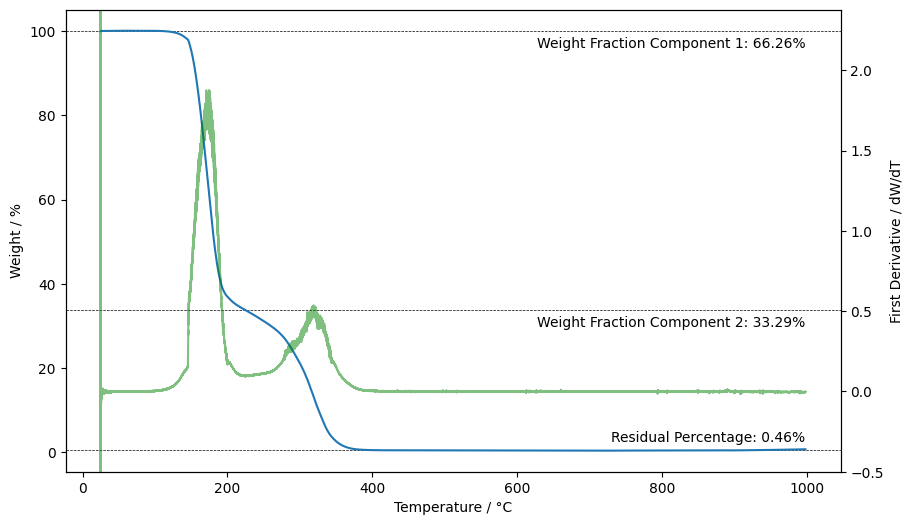

In [6]:
import matplotlib.pyplot as plt

derivative = -np.gradient(df['Weight / %'], df['Temperature / °C'])

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.axhline(100, color='k', linestyle='--', linewidth=0.5)
ax1.axhline(first_drop_to, color='k', linestyle='--', linewidth=0.5)
ax1.axhline(residual, color='k', linestyle='--', linewidth=0.5)

x_offset = 3
ax1.text(df['Temperature / °C'].iloc[-1], 100-x_offset, f"Weight Fraction Component 1: {100-first_drop_to:.2f}%", va='center', ha='right')
ax1.text(df['Temperature / °C'].iloc[-1], first_drop_to-x_offset, f"Weight Fraction Component 2: {first_drop_to - residual:.2f}%", va='center', ha='right')
ax1.text(df['Temperature / °C'].iloc[-1], residual+x_offset, f"Residual Percentage: {residual:.2f}%", va='center', ha='right')

ax1.plot(df['Temperature / °C'], df['Weight / %'])
ax2.plot(df['Temperature / °C'], derivative, c="green", alpha=0.5)
ax2.set_ylim(-0.5, derivative[500:].max()+0.5)

ax1.set_xlabel('Temperature / °C')
ax1.set_ylabel('Weight / %')
ax2.set_ylabel('First Derivative / dW/dT')

plt.show()

In [7]:
import pandas as pd

weight_fractions = []
for analysis in experiment.analyses:
    if analysis.type.name == "Weight change":
        start_temp, end_temp = sorted([v['Value']['Value'] for k,v in analysis.inputs.to_dict().items() if k.startswith('Cursor')])
        weight_fractions.append({
            "start_temp": start_temp,
            "end_temp": end_temp,
            "weight_fraction": analysis.outputs.to_dict()['Weight Percent Loss']['Value']['Value'] / 100
        })
    elif analysis.type.name == "Residue":
        weight_fractions.append({
            "start_temp": analysis.inputs.to_dict()['Cursor x']['Value']['Value'],
            "weight_fraction": analysis.outputs.to_dict()['Residue Percent']['Value']['Value'] / 100
        })

pd.DataFrame(weight_fractions)

,start_temp,end_temp,weight_fraction
0,68.258919,225.030000,0.663565
1,225.030000,435.825134,0.332669
2,995.516479,NaN,0.007127
